# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import community as community_louvain
import matplotlib.colors as mcolors

# **Load and Inspect Dataset**

In [2]:
df = pd.read_csv("../data/ai_job_market_insights.csv")

df.head()

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Remote_Friendly,Job_Growth_Projection
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline


# **Dataset Information**

In [3]:
df.info()

print(f"Null Rows:\n{df.isnull().sum()}")

print(f"Duplicated Rows: {df.duplicated().sum()}")

print(f"Describe:\n{df.describe()}")

print(f"Shape: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_Title              500 non-null    object 
 1   Industry               500 non-null    object 
 2   Company_Size           500 non-null    object 
 3   Location               500 non-null    object 
 4   AI_Adoption_Level      500 non-null    object 
 5   Automation_Risk        500 non-null    object 
 6   Required_Skills        500 non-null    object 
 7   Salary_USD             500 non-null    float64
 8   Remote_Friendly        500 non-null    object 
 9   Job_Growth_Projection  500 non-null    object 
dtypes: float64(1), object(9)
memory usage: 39.2+ KB
Null Rows:
Job_Title                0
Industry                 0
Company_Size             0
Location                 0
AI_Adoption_Level        0
Automation_Risk          0
Required_Skills          0
Salary_USD        

In [4]:
print(f"Number of Unique: {df["Job_Title"].nunique()}")
print(f"Number of Unique: {df["Industry"].nunique()}")
print(f"Number of Unique: {df["Company_Size"].nunique()}")
print(f"Number of Unique: {df["Location"].nunique()}")
print(f"Number of Unique: {df["AI_Adoption_Level"].nunique()}")
print(f"Number of Unique: {df["Automation_Risk"].nunique()}")
print(f"Number of Unique: {df["Required_Skills"].nunique()}")
print(f"Number of Unique: {df["Salary_USD"].nunique()}")
print(f"Number of Unique: {df["Remote_Friendly"].nunique()}")
print(f"Number of Unique: {df["Job_Growth_Projection"].nunique()}")

Number of Unique: 10
Number of Unique: 10
Number of Unique: 3
Number of Unique: 10
Number of Unique: 3
Number of Unique: 3
Number of Unique: 10
Number of Unique: 500
Number of Unique: 2
Number of Unique: 3


# **Salary Distribution**

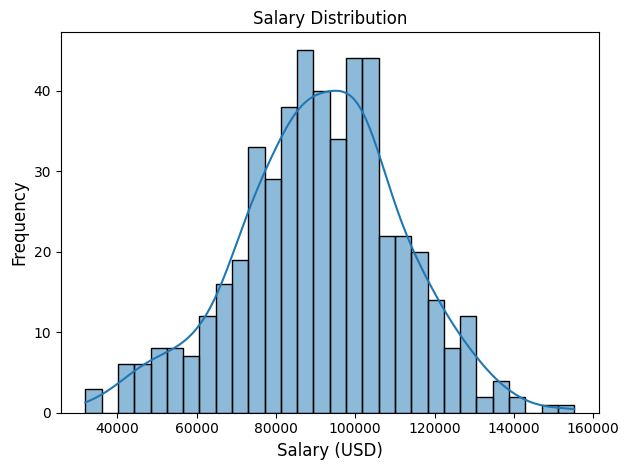

In [5]:
sns.histplot(df['Salary_USD'], bins=30, kde=True)
plt.title("Salary Distribution")
plt.xlabel("Salary (USD)", fontsize=12, color="black")
plt.ylabel("Frequency", fontsize=12, color="black")
plt.tight_layout()
plt.savefig("../assets/images/salary_distribution.png")
plt.show()

# **Job Count by Industry**

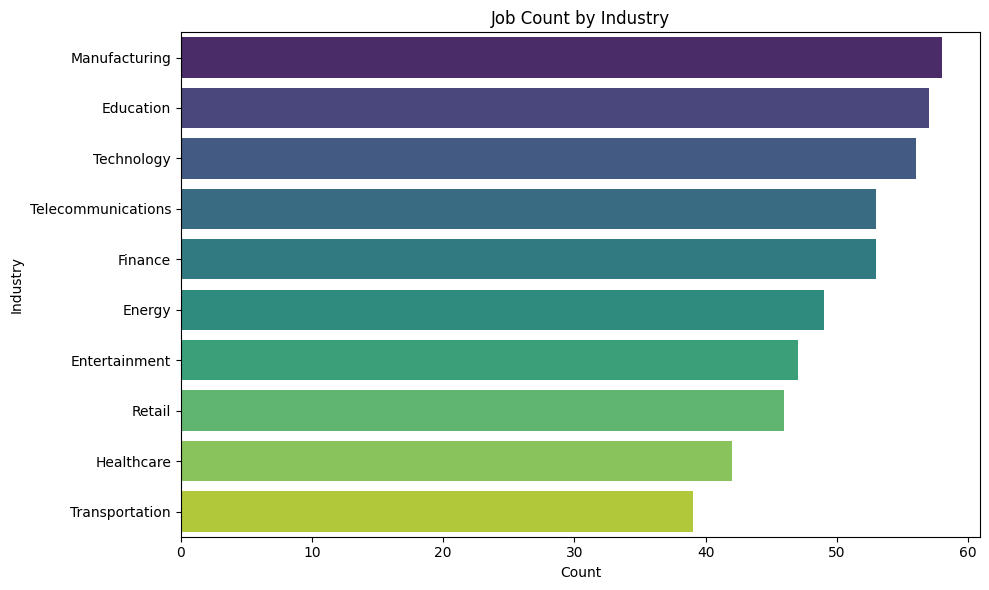

In [6]:
plt.figure(figsize=(10, 6))
industry_counts = df["Industry"].value_counts()
sns.barplot(x=industry_counts.values, y=industry_counts.index, palette="viridis", hue=industry_counts.index)
plt.title("Job Count by Industry")
plt.xlabel("Count")
plt.ylabel("Industry")
plt.tight_layout()
plt.savefig("../assets/images/industry_barh.png")
plt.show()


# **AI Adoption Level Distribution**

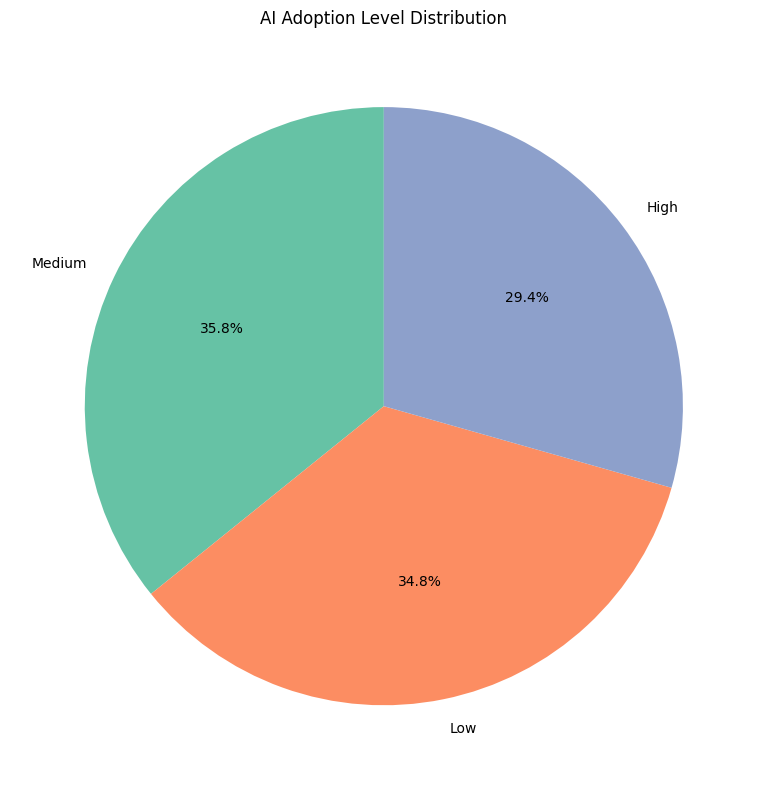

In [7]:
plt.figure(figsize=(8, 8))
ai_adoption_counts = df["AI_Adoption_Level"].value_counts()
sns.set_palette("Set2")
ai_adoption_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, legend=False)
plt.title("AI Adoption Level Distribution")
plt.ylabel('')
plt.tight_layout()
plt.savefig("../assets/images/ai_adoption_pie.png")
plt.show()

# **Salary vs Company Size**

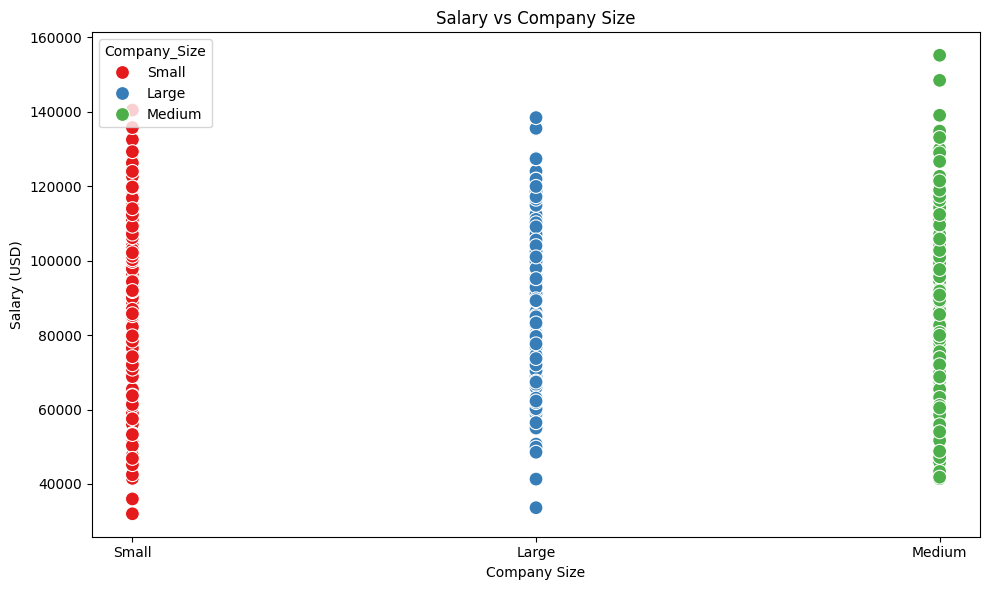

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Company_Size', y='Salary_USD', data=df, hue='Company_Size', palette="Set1", s=100)
plt.title("Salary vs Company Size")
plt.xlabel("Company Size")
plt.ylabel("Salary (USD)")
plt.tight_layout()
plt.savefig("../assets/images/salary_vs_company_size_scatter.png")
plt.show()

# **Salary Distribution by Industry**

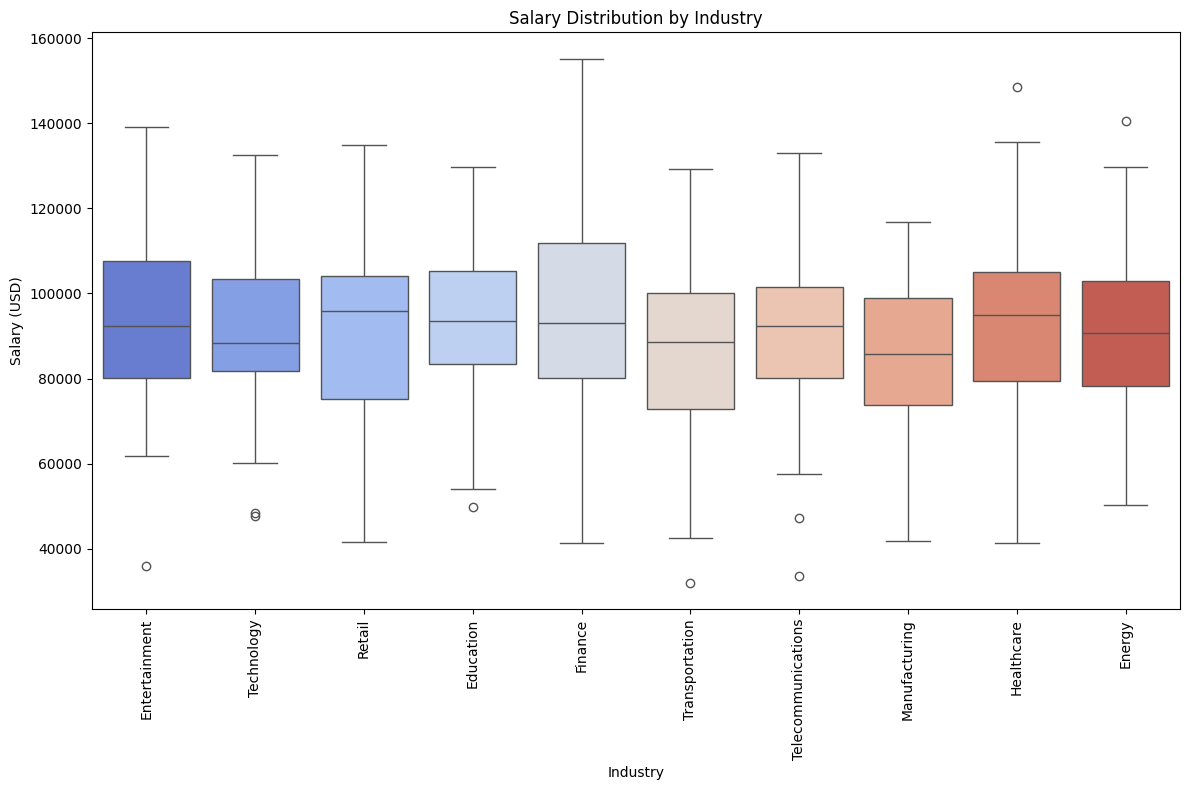

In [9]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Industry', y='Salary_USD', data=df, palette="coolwarm", hue='Industry')
plt.title("Salary Distribution by Industry")
plt.xlabel("Industry")
plt.ylabel("Salary (USD)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../assets/images/salary_distribution_by_industry.png")
plt.show()

# **Job Clustering**

Number of clusters: 3


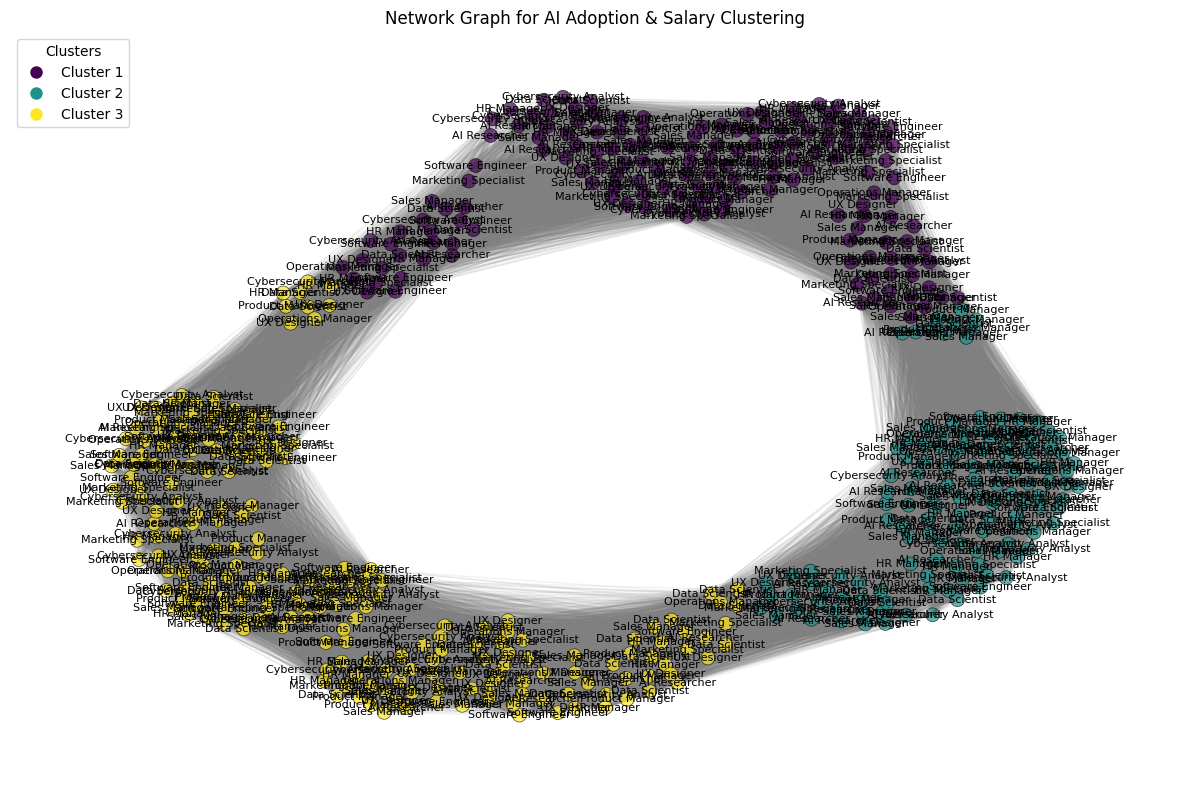

            Salary_USD  AI_Level_Encoded
Cluster                                 
0         92459.595878          2.000000
1        111753.448599          0.914729
2         77732.062926          0.445498


In [10]:
cols = ['Job_Title', 'AI_Adoption_Level', 'Salary_USD']
df_network = df[cols].copy()

le_ai = LabelEncoder()
df_network['AI_Level_Encoded'] = le_ai.fit_transform(df_network['AI_Adoption_Level'])

scaler = StandardScaler()
df_scaled = df_network[['AI_Level_Encoded', 'Salary_USD']]
df_scaled = scaler.fit_transform(df_scaled)

similarity_matrix = cosine_similarity(df_scaled)

threshold = 0.5

G = nx.Graph()
for i in range(len(df)):
    G.add_node(i, label=df_network['Job_Title'][i])

for i in range(len(df)):
    for j in range(i + 1, len(df)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

partition = community_louvain.best_partition(G)

num_clusters = len(set(partition.values()))
print(f"Number of clusters: {num_clusters}")

df_network['Cluster'] = df_network.index.map(partition)

plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.2, iterations=200, seed=42)

nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color="gray")

node_colors = [partition[node] for node in G.nodes]

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))

nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=100, alpha=0.7, 
                               linewidths=0.5, edgecolors='k', nodelist=G.nodes)

nx.draw_networkx_labels(G, pos, labels=df_network['Job_Title'].to_dict(), font_size=8, font_color="black")

plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(i)), markersize=10) 
                   for i in range(num_clusters)],
           labels=[f"Cluster {i+1}" for i in range(num_clusters)],
           title="Clusters", loc="upper left")

plt.title("Network Graph for AI Adoption & Salary Clustering")
plt.axis("off")
plt.tight_layout()

plt.savefig("../assets/images/network_clustering_with_job_titles.png")
plt.show()

cluster_info = df_network.groupby('Cluster').mean(numeric_only=True)
print(cluster_info)
